# W207 Final Project

### Team:  Blair Witch Project

- Kevin Ngo
- Sharon Wu
- Vish Pillai
- Blair Jones

### Project:  Forest Cover Type Prediction

#### The challenge

To predict seven different forest cover types in four different wilderness areas of the Roosevelt National Forest of Northern Colorado with the best accuracy.

These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. 

The data contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

#### An overview of the 4 wilderness areas
    - Rawah Wilderness Area
    - Neota Wilderness Area
    - Comanche Peak Wilderness Area
    - Cache la Poudre Wilderness Area

<table><tr>
<td> <img src="locations1.png" alt="Drawing" style="width: 200px;"/> </td>
<td> <img src="locations2.png" alt="Drawing" style="width: 350px;"/> </td>
</tr></table>

# EDA

In [1]:
#!pip install seaborn  # uncomment if not already installed
#!pip install keras # uncomment if not already installed
#!pip install tensorflow # uncomment if not already installed

In [2]:
%matplotlib inline
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.ensemble import *
from sklearn.preprocessing import normalize
import math
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix as cm
import seaborn as sn
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from itertools import combinations 

In [3]:
df_train = pd.read_csv('forest-cover-type-prediction/train.csv')
df_train.sample(5)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
2786,2787,2286,335,5,150,41,660,209,233,163,...,0,0,0,0,0,0,0,0,0,3
10365,10366,3239,40,20,228,2,2640,218,193,103,...,0,0,0,0,0,0,0,0,0,1
5504,5505,2332,95,13,0,0,216,240,221,110,...,0,0,0,0,0,0,0,0,0,4
13641,13642,3313,164,7,182,17,3900,227,242,149,...,0,0,0,0,0,0,1,0,0,7
4798,4799,2211,153,35,90,31,1597,237,218,80,...,0,0,0,0,0,0,0,0,0,3


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

In [5]:
df_train_pt = df_train.pivot_table(df_train.columns,
               ['Cover_Type'], aggfunc='mean')
df_train_pt

,Aspect,Elevation,Hillshade_3pm,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Id,Slope,...,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Vertical_Distance_To_Hydrology,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
Cover_Type,,,,,,,,,,,,,,,,,,,,,
1,159.463426,3128.025926,144.065741,211.690278,223.248611,1994.412963,271.507407,2579.715741,7996.077778,13.112963,...,0.000000,0.000000,0,0.000000,0.000463,41.281481,0.491667,0.083796,0.424537,0.000000
2,151.097222,2922.540278,142.950926,214.044444,225.369907,2155.277315,287.728704,2425.791667,6312.696759,13.423611,...,0.000000,0.003241,0,0.000463,0.004167,47.337963,0.525000,0.030556,0.435185,0.009259
3,173.672685,2398.423148,141.549537,201.655556,216.561111,916.909722,210.723148,969.595833,8127.537500,20.628704,...,0.025463,0.114815,0,0.000000,0.000000,64.081944,0.000000,0.000000,0.399537,0.600463
4,138.099537,2223.420370,111.808796,227.968056,216.889815,860.540741,104.537500,915.100463,6354.585648,18.468519,...,0.018056,0.112963,0,0.000000,0.000000,40.143519,0.000000,0.000000,0.000000,1.000000
5,137.992130,2786.801389,121.392593,223.368981,218.317130,1530.388889,208.873148,1329.318519,6486.800463,16.724537,...,0.000000,0.000000,0,0.000000,0.000000,50.871296,0.396296,0.000000,0.603704,0.000000
6,180.617130,2423.276852,147.682407,193.562963,209.960648,1057.654167,160.095370,1064.980556,8061.305093,18.986111,...,0.032870,0.069907,0,0.000000,0.000000,44.873611,0.000000,0.000000,0.445370,0.554630
7,155.794444,3362.769907,136.193981,216.639815,222.412037,2062.847222,346.904630,2713.659722,9584.496759,14.166667,...,0.000000,0.000000,0,0.000000,0.000000,68.945833,0.252315,0.116667,0.631019,0.000000


In the data we can see that:
- training dataset has 15120 entries and 56 columns
- there are no missing values
- there do not appear to be any duplicates
- data values are unscaled
- Wilderness_Area and Soil_Type columns have binary values (0,1)
- each row is assigned to one distinct Wilderness Area column
- each row is assigned to one distinct Soil Type column
- Vertical_Distance_To_Hydrology contains negative values (ex. if the location is at a lower elevation than the water source)
- the data is evenly distributed between each Cover Type, with 2,160 rows each

Cover_Type is our target column.

In [6]:
# This creates a dataset for EDA manipulation
df_eda = df_train.copy()

# This creates 2 new columns that summarize the Wilderness Area and Soil Type columns for ease of visualization
df_eda['Wilderness_Area'] = df_eda.iloc[:,11:15].idxmax(axis=1).str.replace('Wilderness_Area','')
df_eda['Soil_Type'] = df_eda.iloc[:,16:55].idxmax(axis=1).str.replace('Soil_Type','')

As seen in the next plot, the distribution is skewed across Wilderness Area.

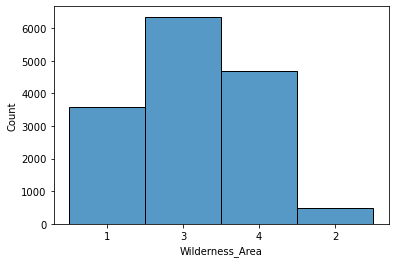

In [7]:
sn.histplot(data=df_eda, x='Wilderness_Area')

We see that Elevation varies significantly for the different types of Cover and across Wilderness Areas.

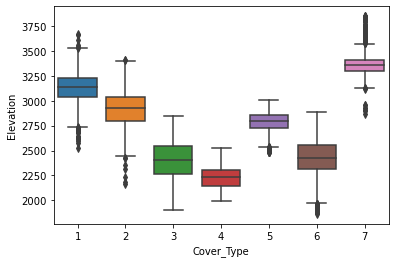

In [8]:
sn.boxplot(data=df_eda, x='Cover_Type', y='Elevation')

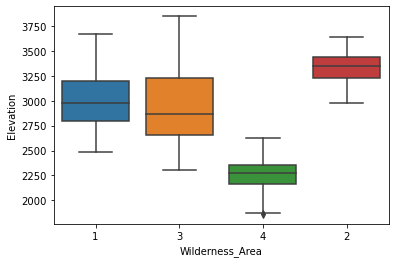

In [9]:
sn.boxplot(data=df_eda, x='Wilderness_Area', y='Elevation')

Slope and Aspect appear to be similar across the Cover Types.

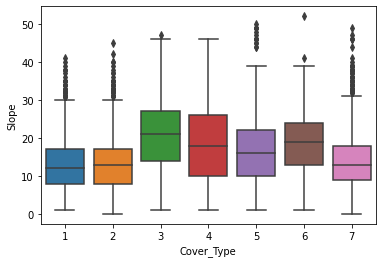

In [10]:
sn.boxplot(data=df_eda, x='Cover_Type', y='Slope')

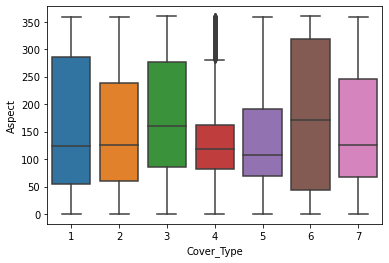

In [11]:
sn.boxplot(data=df_eda, x='Cover_Type', y='Aspect')

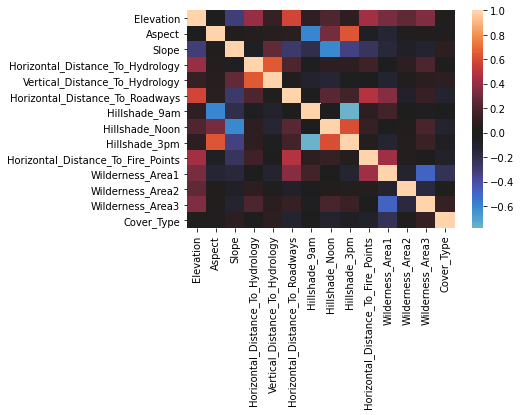

In [12]:
small_eda = df_eda.iloc[:,1:14]
small_eda['Cover_Type'] = df_eda['Cover_Type']
sn.heatmap(small_eda.corr(), center=0)

## Feature: Cover_Type & Wilderness_Areas

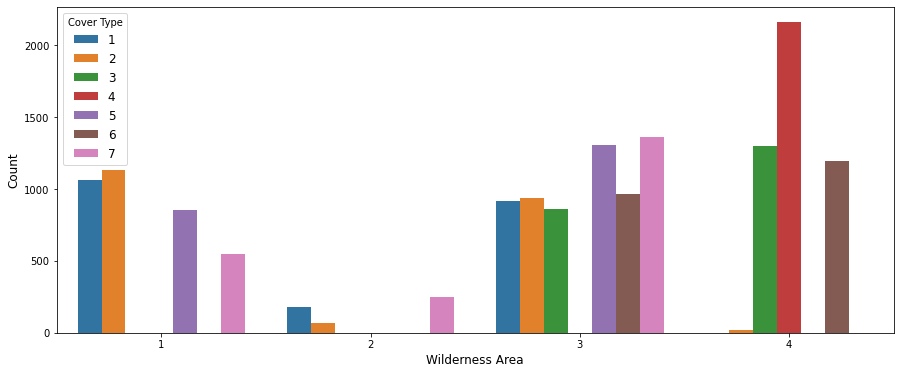

In [13]:
plt.figure(figsize=(15,6))   
order = ["1","2","3","4"]
ax = sn.countplot(x= "Wilderness_Area", hue = "Cover_Type", data = df_eda, order=order)
ax.set_xlabel("Wilderness Area",fontsize=12)
ax.set_ylabel("Count",fontsize=12)
plt.legend(title="Cover Type", loc='upper left',fontsize=12)
plt.show()

Some cover types only belong specific wilderness areas, in this case wilderness areas could be a significant variables in the predictive model.

## Data Transformations

In [14]:
# normalization
from sklearn.preprocessing import normalize

col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
df_train_norm = df_train.copy()
df_train_norm[col_normalize] = normalize(df_train[col_normalize])



to be completed

copy from Sharon/Vish/Kevin notebooks for EDA modeling examples 

                 - WITHOUT TRAINING RESULTS 
                 - THIS IS JUST FOR PCA/Feature Selection
        
        
        

# Hypothesis

Based on the EDA, we believe that a Decision Tree approach will yield the best classification results and also serve as the basis for a good predictor on the test dataset.

One features is strongly linked to a specific Cover Type:  Cover Type 4 is only found in Wilderness Area 4.  However there is significant overlap of other features for all Cover Types and Wildnerness Areas.  This suggests that a strategy using smaller Decision Trees to classify sub-groupings of features will be effective.

# Modeling

There are many models we can test, including:
- Decision Tree
- Random Forest
- XGBoost
- Neural Network
- etc.

This first pass will examine RandomForest against the Training dataset, using random sampling to extract a sub-training set and then evaluating performance of the trained classifier against the remaining data in the training data.  

This way we avoid touching the true Testing dataset until we are satisfied that our model performs as expected and should also generalize.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn import model_selection

In [16]:
np.set_printoptions(precision=5)
def score_model(model,df, return_val=False, return_train=False, display=True, return_acc=False, return_time=False, show_weights=False):
    X , Y = df.drop(columns=['Id','Cover_Type']).to_numpy(), df.Cover_Type.to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.13, random_state=0)
    start = time.time()
    results = model_selection.cross_val_score(model, X, Y, cv=kfold)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    acc = accuracy_score(y_val, pred)
    end = time.time()
    print('\nModel:',type(model).__name__)
    print('\tcv acc:', round(results.mean(),4))
    print('\tsplit acc:', round(acc,4))
    print('\ttime taken:', round(end-start, 4))
    if display:
        matrix = cm(y_val, pred)
        print('\t', matrix.diagonal() / matrix.sum(axis=1))

        disp = plot_confusion_matrix(model, X_val, y_val, display_labels=set(y_train), cmap=plt.cm.Blues, normalize='true')
        plt.show()
    
    if show_weights:
        for w,k in sorted(list(zip(model.feature_importances_, df.drop(columns=['Id','Cover_Type']).columns)), key=lambda x: x[0]):
            print(k,w)
            
    # return all data
    return_data = [model]
    if return_train:
        return_data += [X_train, y_train]
    if return_val:
        return_data += [X_val, y_val]
    if return_acc:
        return_data += [acc]
    if return_time:
        return_data += [end-start]
    return tuple(return_data)

In [17]:
kfold = model_selection.KFold(n_splits=10, random_state=0, shuffle=True)


Model: DecisionTreeClassifier
	cv acc: 0.7877
	split acc: 0.7716
	time taken: 1.4905
	 [0.70748 0.55797 0.7417  0.90036 0.89568 0.7309  0.87547]


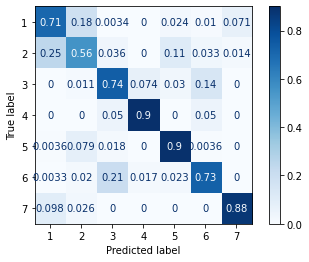


Model: RandomForestClassifier
	cv acc: 0.8743
	split acc: 0.8591
	time taken: 9.7391
	 [0.76871 0.7029  0.83764 0.9573  0.97122 0.82392 0.96226]


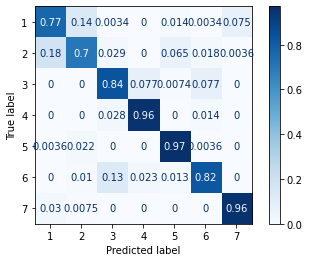

In [18]:
models = []
for clf in [
    DecisionTreeClassifier(max_depth=14, random_state=0), # 14 was determine by iterating
    RandomForestClassifier(n_jobs=-1, random_state=0),]:
    
    models.append(score_model(clf,df_train_norm))

RandomForest performs much better than the DecisionTree Classifier.

Next we will examine the ExtraTreesClassifier.


Model: ExtraTreesClassifier
	cv acc: 0.8849
	split acc: 0.881
	time taken: 10.4503
	 [0.79932 0.76087 0.86347 0.95374 0.97842 0.8505  0.96981]


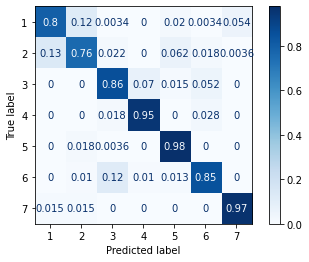

In [19]:
# Determining RF model - ExtraTreesClassifier

models.append(score_model(ExtraTreesClassifier(n_jobs=-1, random_state=0),df_train_norm))

The ExtraTrees Classifier improved upon the performance of RandomForest for several categories.

# Current Status

After normalization, we can see the weaknesses of our 'ExtraTrees' model is the cluster involving Cover Type '1' and '2'. We will focus now on optimizing our model to better classify this smaller cluster and to get our cv accuracy at 90%+.


work in progress


Model: ExtraTreesClassifier
	cv acc: 0.8901
	split acc: 0.8845
	time taken: 10.5129
	 [0.80952 0.73551 0.84502 0.96085 0.98201 0.89037 0.97358]


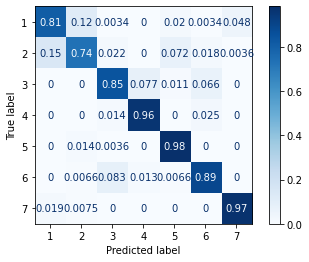

In [20]:
col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 
                 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
                 'Horizontal_Distance_To_Roadways']
df_train_norm = df_train.copy()
df_train_norm[col_normalize] = normalize(df_train[col_normalize])
df_train_norm['log_Horizontal_Distance_To_Roadways'] = (df_train['Horizontal_Distance_To_Roadways']+1).apply(np.log)
best_m, best_X_train, best_y_train, best_X_val, best_y_val = score_model(ExtraTreesClassifier(n_jobs=-1, random_state=0), df_train_norm, return_train = True, return_val = True)

# Heatmap by sub-selection of highly confounded Cover_Types

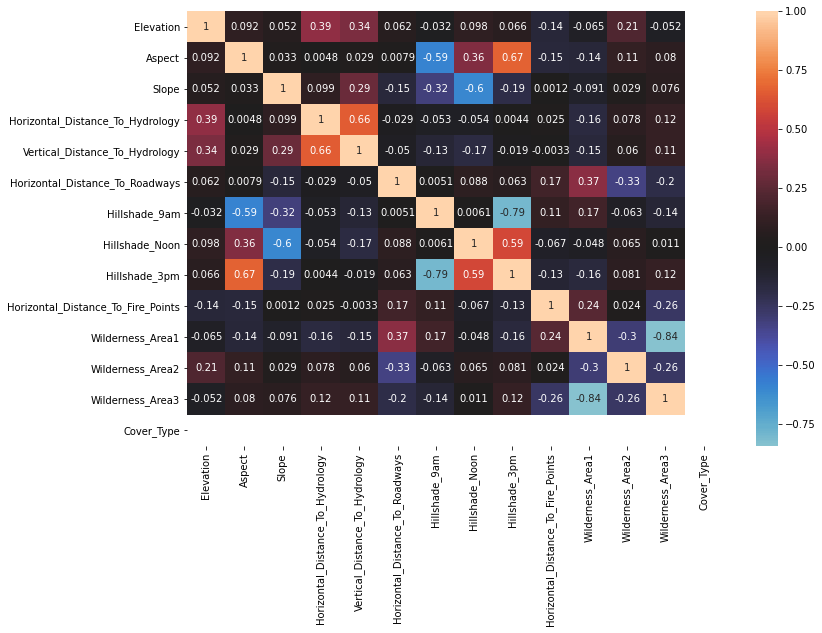

In [21]:
# looking more closely at covers 1 and 2
fig = plt.figure(1, figsize=(12, 8))
maska = small_eda['Cover_Type']==1
#maskb = small_eda['Cover_Type']==2
#mask = maska | maskb
small_ab_eda = small_eda[maska]
sn.heatmap(small_ab_eda.corr(), annot=True, center=0)

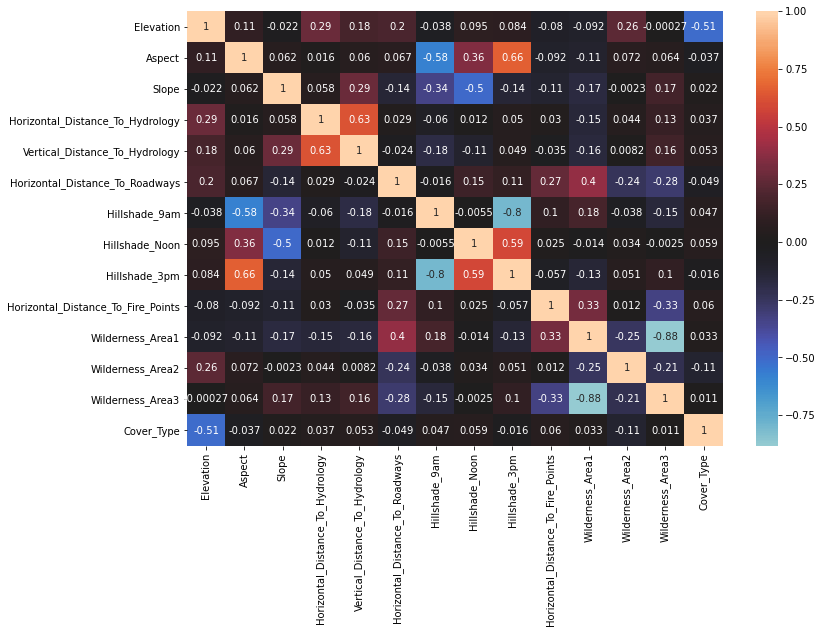

In [22]:
# looking more closely at covers 1 and 2
fig = plt.figure(1, figsize=(12, 8))
maska = small_eda['Cover_Type']==1
maskb = small_eda['Cover_Type']==2
mask = maska | maskb
small_ab_eda = small_eda[mask]
sn.heatmap(small_ab_eda.corr(), annot=True, center=0)

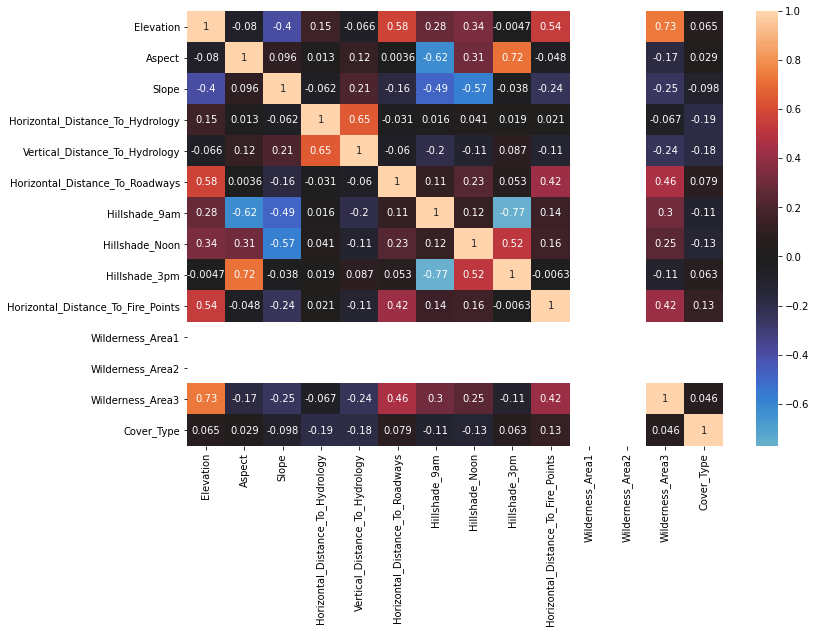

In [23]:
# looking more closely at covers 3 and 6
fig = plt.figure(1, figsize=(12, 8))
maska = small_eda['Cover_Type']==3
maskb = small_eda['Cover_Type']==6
mask = maska | maskb
small_ab_eda = small_eda[mask]
sn.heatmap(small_ab_eda.corr(), annot=True, center=0)

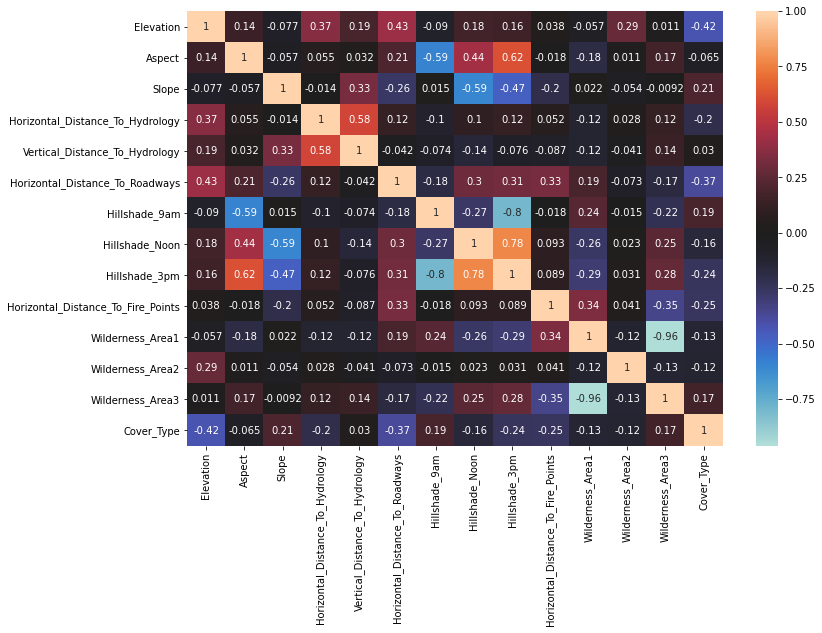

In [24]:
# looking more closely at covers 2 and 5
fig = plt.figure(1, figsize=(12, 8))
maska = small_eda['Cover_Type']==2
maskb = small_eda['Cover_Type']==5
mask = maska | maskb
small_ab_eda = small_eda[mask]
sn.heatmap(small_ab_eda.corr(), annot=True, center=0)

In [25]:
col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 
                 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
                 'Horizontal_Distance_To_Roadways']
df_train_norm = df_train.copy()
df_train_norm[col_normalize] = normalize(df_train[col_normalize])
df_train_norm['log_Horizontal_Distance_To_Roadways'] = (df_train['Horizontal_Distance_To_Roadways']+1).apply(np.log)

# ExtraTreesClassifier

ExtraTreesClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)


Model: ExtraTreesClassifier
	cv acc: 0.8546
	split acc: 0.8469
	time taken: 11.8228
	 [0.7551  0.67391 0.79336 0.9573  0.95683 0.83721 0.96226]


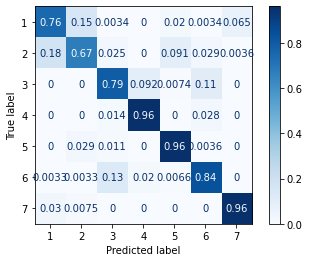

In [26]:
best_m, best_X_train, best_y_train, best_X_val, best_y_val = score_model(
    ExtraTreesClassifier(n_jobs=-1, random_state=0, n_estimators=200, min_samples_leaf=2, criterion='entropy'), 
    df_train_norm, return_train = True, return_val = True)

# GradientBoostingClassifier

sklearn.ensemble.GradientBoostingClassifier(*, loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)


Model: GradientBoostingClassifier
	cv acc: 0.8018
	split acc: 0.7818
	time taken: 317.6685
	 [0.68367 0.56159 0.71956 0.96085 0.8705  0.74751 0.93962]


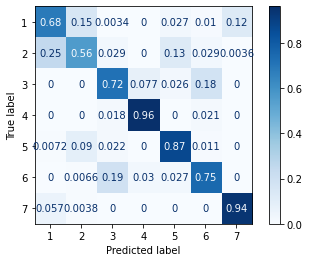

In [27]:
# runs VERY slow for no noticeable gain (before any PCA)
if False:
    # this took about 5 minutes to run
    from sklearn.ensemble import GradientBoostingClassifier
    best_m, best_X_train, best_y_train, best_X_val, best_y_val = score_model(
        GradientBoostingClassifier(random_state=0), 
        df_train_norm, return_train = True, return_val = True)

In [28]:
#!pip3 install xgboost


Model: XGBClassifier
	cv acc: 0.8649
	split acc: 0.854
	time taken: 193.2226
	 [0.78231 0.65942 0.83395 0.97153 0.93165 0.84053 0.96604]


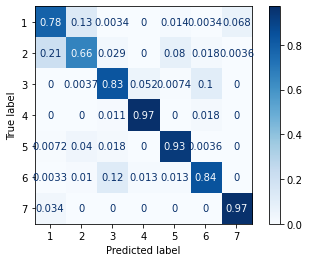

In [29]:
# runs VERY slow for no noticeable gain (before any PCA)
if False:
    from xgboost import XGBClassifier
    best_m, best_X_train, best_y_train, best_X_val, best_y_val = score_model(
        XGBClassifier(n_jobs=-1, random_state=0), 
        df_train_norm, return_train = True, return_val = True)

# PCA Analysis

In [56]:
col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 
                 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
                 'Horizontal_Distance_To_Roadways']
df_train_norm = df_train.copy()
df_train_norm[col_normalize] = normalize(df_train[col_normalize])
#df_train_norm['log_Horizontal_Distance_To_Roadways'] = (df_train['Horizontal_Distance_To_Roadways']+1).apply(np.log)
#best_m, best_X_train, best_y_train, best_X_val, best_y_val = score_model(ExtraTreesClassifier(n_jobs=-1, random_state=0), df_train_norm, return_train = True, return_val = True)
df_train_norm.insert(len(df_train_norm.columns)-1, 'Cover_Type', df_train_norm.pop('Cover_Type'))
#df_train_norm

In [57]:
maska = df_train['Cover_Type']==1
maskb = df_train['Cover_Type']==2
mask = maska | maskb
df_sub = df_train_norm[mask] #need to use normalized data for PCA.  unsure whether should use log transform of horiz_dist_to_hydro

In [58]:
from mpl_toolkits.mplot3d import Axes3D
centers = [[1, 1], [-1, -1], [1, -1]]

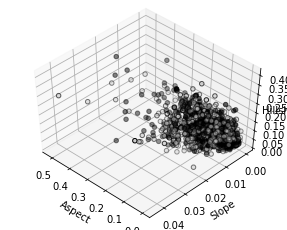

In [59]:
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()

cols=['Aspect', 'Slope', 'Hillshade_9am']
X = df_sub[cols]
y = df_sub.iloc[:,-1:]

for label in [1,2]:#,3,4,5,6,7]:
    ax.text3D(X[y['Cover_Type'] == label].iloc[:,0].mean(),
              X[y['Cover_Type'] == label].iloc[:,1].mean() + 1.5,
              X[y['Cover_Type'] == label].iloc[:,2].mean(), str(label),
              horizontalalignment='center',
              bbox=dict(alpha=1, edgecolor='w', facecolor='w'))

# Reorder the labels to have colors matching the cluster results
#y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], X.iloc[:, 2], c=y, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

ax.set_xlabel(cols[0])
ax.set_ylabel(cols[1])
ax.set_zlabel(cols[2])
ax.zaxis.set_rotate_label(False) 
if False:
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])

plt.show()

In [60]:
X[y['Cover_Type'] == 1].iloc[:,2].mean()

0.07513748784647789

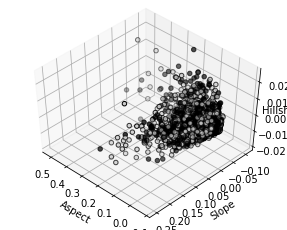

In [61]:
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()

cols=['Aspect', 'Slope', 'Hillshade_9am']
X = df_sub[cols]
y = df_sub.iloc[:,-1:]

pca = PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for label in [1,2]:#,3,4,5,6,7]:
    ax.text3D(X[y['Cover_Type'] == label,0].mean(),
              X[y['Cover_Type'] == label,1].mean() + 1.5,
              X[y['Cover_Type'] == label,2].mean(), str(label),
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

# Reorder the labels to have colors matching the cluster results
#y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

ax.set_xlabel(cols[0])
ax.set_ylabel(cols[1])
ax.set_zlabel(cols[2])
ax.zaxis.set_rotate_label(False) 

if False:
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])

plt.show()

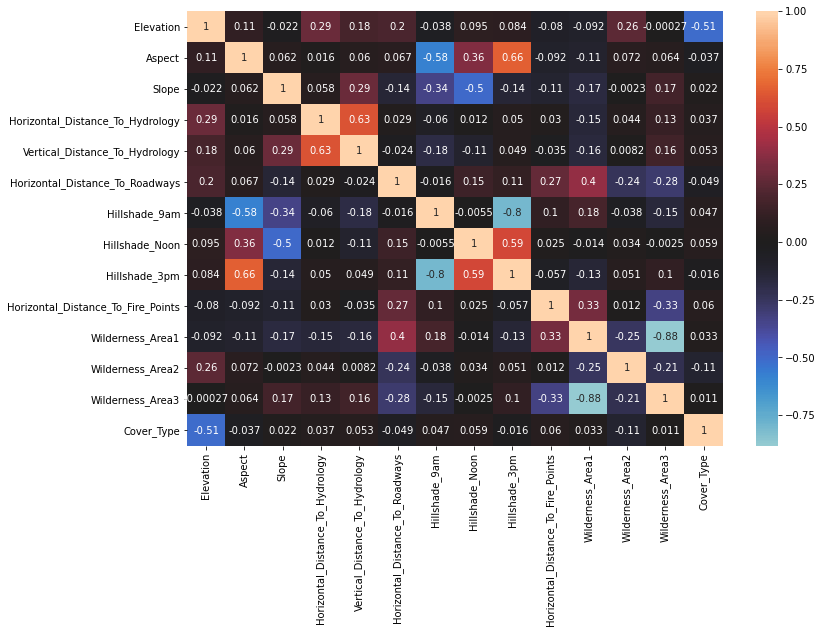

In [62]:
# looking more closely at covers 1 and 2
fig = plt.figure(1, figsize=(12, 8))
maska = small_eda['Cover_Type']==1
maskb = small_eda['Cover_Type']==2
mask = maska | maskb
small_ab_eda = small_eda[mask]
sn.heatmap(small_ab_eda.corr(), annot=True, center=0)

In [179]:
from sklearn.preprocessing import StandardScaler
col_normalize = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 
                 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
                 'Horizontal_Distance_To_Roadways']
df_train_norm = df_train.copy()

if False: # method 1
    df_train_norm[col_normalize] = normalize(df_train[col_normalize])
else: # method 2
    scaler = StandardScaler()
    scaler.fit(df_train_norm[col_normalize])
    df_train_norm[col_normalize] = scaler.transform(df_train_norm[col_normalize])

# move Cover_Type to be last column
df_train_norm.insert(len(df_train_norm.columns)-1, 'Cover_Type', df_train_norm.pop('Cover_Type'))
#df_train_norm

In [180]:
if False: # filter to a subset of cover types
    maska = df_train['Cover_Type']==1
    maskb = df_train['Cover_Type']==2
    mask = maska | maskb
    df_sub = df_train_norm[mask] #need to use normalized data for PCA.  unsure whether should use log transform of horiz_dist_to_hydro
else: # use all cover types
    df_sub = df_train_norm

In [181]:
# revert binary columns Wilderness Area and Soil Type back to categories
#df_sub['Wilderness_Area'] = df_sub.iloc[:,11:15].idxmax(axis=1).str.replace('Wilderness_Area','')
#df_sub['Soil_Type'] = df_sub.iloc[:,16:55].idxmax(axis=1).str.replace('Soil_Type','')
#df_sub.insert(len(df_sub.columns)-1, 'Cover_Type', df_sub.pop('Cover_Type'))

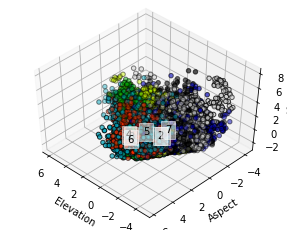

In [182]:
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()

#cols=['Aspect', 'Slope', 'Wilderness_Area', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Roadways', 'Vertical_Distance_To_Hydrology']
cols=['Elevation','Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Roadways', 'Vertical_Distance_To_Hydrology']

X = df_sub[cols]
y = df_sub.iloc[:,-1:]

pca = PCA()
pca.fit(X)
X = pca.transform(X)

for label in [1,2,3,4,5,6,7]:
    ax.text3D(X[y['Cover_Type'] == label,0].mean(),
              X[y['Cover_Type'] == label,1].mean() + 1.5,
              X[y['Cover_Type'] == label,2].mean(), str(label),
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

# Reorder the labels to have colors matching the cluster results
#y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

ax.set_xlabel(cols[0])
ax.set_ylabel(cols[1])
ax.set_zlabel(cols[2])
ax.zaxis.set_rotate_label(False) 

if False:
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])

plt.show()

[0.286 0.228 0.183 0.106 0.055 0.048 0.04  0.029 0.025 0.   ]
[0.286 0.515 0.697 0.803 0.858 0.906 0.946 0.975 1.    1.   ]


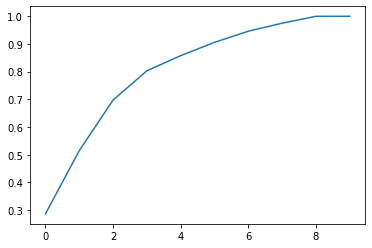

In [183]:
print(np.round(pca.explained_variance_ratio_, 3))
print(np.round(np.cumsum(pca.explained_variance_ratio_), 3))

plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [194]:
np.abs(np.round(pca.components_,2))

array([[0.33, 0.32, 0.33, 0.24, 0.43, 0.47, 0.2 , 0.25, 0.35, 0.03],
       [0.39, 0.41, 0.2 , 0.49, 0.02, 0.37, 0.21, 0.35, 0.31, 0.06],
       [0.13, 0.1 , 0.38, 0.21, 0.28, 0.03, 0.54, 0.  , 0.03, 0.64],
       [0.14, 0.1 , 0.38, 0.31, 0.43, 0.03, 0.34, 0.46, 0.39, 0.28],
       [0.43, 0.14, 0.13, 0.07, 0.03, 0.1 , 0.07, 0.75, 0.41, 0.14],
       [0.19, 0.63, 0.29, 0.46, 0.33, 0.27, 0.14, 0.18, 0.11, 0.16],
       [0.58, 0.34, 0.  , 0.05, 0.13, 0.1 , 0.12, 0.11, 0.64, 0.29],
       [0.31, 0.41, 0.55, 0.03, 0.52, 0.18, 0.28, 0.05, 0.17, 0.14]])

In [185]:
pca.score(X,y)

-135.7977715002702

# Modeling

In [169]:
df_train_norm

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,-0.925271,-0.988557,-0.657563,-0.713258,-2.487165,-1.133610,-1.206098,-0.971599,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,-0.914908,-1.004394,-0.722054,-0.737516,-2.566572,-1.130956,-1.193918,-0.957735,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,-0.784003,-0.904157,-0.677011,-0.475658,-0.848260,-1.149083,-1.239072,-1.046972,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,-0.758313,-0.772758,-0.713789,-0.284363,-0.915452,-1.143927,-1.241846,-1.085134,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,-0.934830,-1.004106,-0.807740,-0.717337,-2.563498,-1.126790,-1.191498,-0.956743,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15116,2607,0.844413,0.497077,0.528859,-0.597680,-0.972548,-0.111688,0.606192,1.271271,...,0,0,0,0,0,0,0,0,0,3
15116,15117,2603,-0.156903,0.141255,2.535157,2.280281,-1.213718,0.428188,0.182605,-0.357957,...,0,0,0,0,0,0,0,0,0,3
15117,15118,2492,0.151481,0.863090,1.487366,1.488026,-1.758317,0.896549,0.603293,-0.232426,...,0,0,0,0,0,0,0,0,0,3
15118,15119,2487,0.819847,1.644727,0.862881,1.681326,-1.854996,1.282317,1.437245,0.728257,...,0,0,0,0,0,0,0,0,0,3


In [186]:
col_normalize = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 
                 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
                 'Horizontal_Distance_To_Roadways']
df_train_norm = df_train.copy()

if False: # method 1
    df_train_norm[col_normalize] = normalize(df_train[col_normalize])
else: # method 2
    scaler = StandardScaler()
    scaler.fit(df_train_norm[col_normalize])
    df_train_norm[col_normalize] = scaler.transform(df_train_norm[col_normalize])

# move Cover_Type to be last column
df_train_norm.insert(len(df_train_norm.columns)-1, 'Cover_Type', df_train_norm.pop('Cover_Type'))



In [199]:
# rebuild the PCA model selecting n_components to reach 97% threshold on explained variance ratio shown above
cols=['Elevation','Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Roadways', 'Vertical_Distance_To_Hydrology']

pca = PCA(n_components=8).fit(df_train_norm[cols])
df_train_pca = pd.DataFrame(pca.transform(df_train_norm[cols]))
df_train_pca['Id'] = df_train_norm['Id']
df_train_pca['Cover_Type'] = df_train_norm['Cover_Type']

In [200]:
df_train_pca.head()

,0,1,2,3,4,5,6,7,Id,Cover_Type
0,-1.181869,-1.800827,-1.477151,0.725734,4.056435,0.259556,0.693051,-0.033234,1,5
1,-1.235252,-1.661943,-1.733997,0.680543,4.055687,0.255570,0.730155,0.021511,2,5
2,-1.939848,-2.469035,-0.449815,1.305233,2.801486,-1.077333,-0.340788,0.030539,3,2
3,-1.447959,-2.372965,0.437916,1.491310,2.826259,-1.782856,-0.491777,0.658217,4,2
4,-1.112931,-1.647369,-1.827972,0.743108,4.015682,0.285661,0.649431,0.128236,5,5


In [201]:
df_train_pca.shape

(15120, 10)


Model: ExtraTreesClassifier
	cv acc: 0.7861
	split acc: 0.7742
	time taken: 10.4838
	 [0.66667 0.57609 0.71587 0.91103 0.89209 0.74086 0.9283 ]


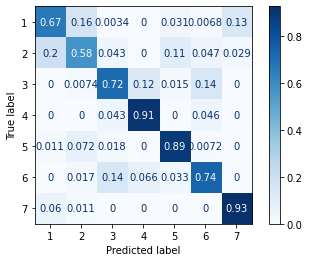

In [203]:
best_m, best_X_train, best_y_train, best_X_val, best_y_val = score_model(ExtraTreesClassifier(n_jobs=-1, random_state=0), df_train_pca, return_train = True, return_val = True)

# Trying PCA on ALL columns

In [215]:
df_train_norm = df_train.copy()
pca_cols = df_train.columns[1:-1]

scaler = StandardScaler()
scaler.fit(df_train_norm[pca_cols])
df_train_norm[pca_cols] = scaler.transform(df_train_norm[pca_cols])

#df_train_norm

In [216]:
X = df_train_norm[pca_cols]
y = df_train_norm.iloc[:,-1:]

pca = PCA()
pca.fit(X)
X = pca.transform(X)


[0.082 0.058 0.046 0.039 0.03  0.026 0.023 0.022 0.022 0.02  0.02  0.02
 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.019
 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019
 0.019 0.018 0.016 0.013 0.012 0.01  0.008 0.007 0.006 0.005 0.004 0.003
 0.001 0.    0.    0.    0.    0.   ]
[0.082 0.139 0.185 0.224 0.255 0.281 0.304 0.326 0.348 0.368 0.389 0.409
 0.429 0.449 0.469 0.489 0.509 0.529 0.549 0.568 0.588 0.608 0.627 0.647
 0.666 0.686 0.705 0.724 0.744 0.763 0.782 0.802 0.821 0.84  0.859 0.879
 0.898 0.916 0.932 0.945 0.957 0.967 0.974 0.981 0.987 0.992 0.996 0.999
 1.    1.    1.    1.    1.    1.   ]


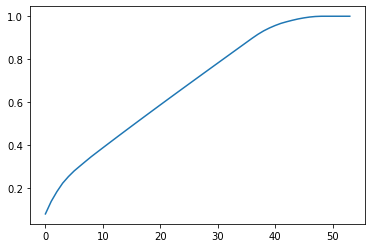

In [217]:
print(np.round(pca.explained_variance_ratio_, 3))
print(np.round(np.cumsum(pca.explained_variance_ratio_), 3))

plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [218]:
pca.score(X,y)

-inf

In [219]:
pca = PCA(n_components=46).fit(df_train_norm[pca_cols])
df_train_pca = pd.DataFrame(pca.transform(df_train_norm[pca_cols]))
df_train_pca['Id'] = df_train_norm['Id']
df_train_pca['Cover_Type'] = df_train_norm['Cover_Type']


Model: ExtraTreesClassifier
	cv acc: 0.8385
	split acc: 0.8362
	time taken: 10.5056
	 [0.73469 0.67754 0.80812 0.93238 0.92446 0.81728 0.96981]


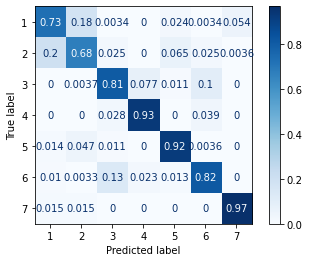

In [220]:
best_m, best_X_train, best_y_train, best_X_val, best_y_val = score_model(ExtraTreesClassifier(n_jobs=-1, random_state=0), df_train_pca, return_train = True, return_val = True)

In [ ]:

train['Euclidian_Distance_To_Hydrology']= (train['Horizontal_Distance_To_Hydrology']**2 + train['Vertical_Distance_To_Hydrology']**2)**0.5

